In [1]:
api_key = ""
channel_id = ""

In [2]:
from googleapiclient.discovery import build
youtube = build("youtube", "v3", developerKey=api_key)

In [3]:
def get_channel_videos(channel_id):
    res = youtube.channels().list(id=channel_id,
                                 part="contentDetails").execute()
    playlist_id = res["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    
    videos = []
    next_page_token = None
    
    while 1:
        res = youtube.playlistItems().list(playlistId=playlist_id,
                                          part="snippet",
                                          maxResults=50,
                                          pageToken=next_page_token).execute()
        videos += res["items"]
        next_page_token = res.get("nextPageToken")
        
        if next_page_token is None:
            break
    
    return videos

In [4]:
videos = get_channel_videos(channel_id)

In [5]:
res = youtube.videos().list(id=videos[0]["snippet"]["resourceId"]["videoId"],
                           part="statistics").execute()

In [6]:
video_ids = list(map(lambda x:x['snippet']['resourceId']['videoId'], videos))

In [7]:
def get_videos_stats(video_ids):
    stats = []
    for i in range(0, len(video_ids), 50):
        res = youtube.videos().list(id=','.join(video_ids[i:i+50]),
                                   part='statistics').execute()
        stats += res['items']
    return stats

In [8]:
stats = get_videos_stats(video_ids)

# List Before Dataframe

In [38]:
publishedAt = []
title = []
viewCount = []
likeCount = []
dislikeCount = []
commentCount = []

for i in range(len(videos)):
    publishedAt.append(videos[i]['snippet']['publishedAt'])
    title.append(videos[i]['snippet']['title'])
    viewCount.append(stats[i]['statistics']['viewCount'])
    likeCount.append(stats[i]['statistics']['likeCount'])
    dislikeCount.append(stats[i]['statistics']['dislikeCount'])
    commentCount.append(stats[i]['statistics']['commentCount'])

# Dataframe
공개일, 제목, 조회수, 좋아요수, 싫어요수, 댓글수

zip을 이용하여 list를 vertical하게 DataFrame으로 만든다.  
참고 링크 : https://stackoverflow.com/questions/54644722/how-to-vertically-align-lists-to-pandas-dataframe-in-python

In [53]:
import pandas as pd
names = ['publishedAt', 'title', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount']
df = pd.DataFrame(data=list(zip(publishedAt, title, viewCount, likeCount, dislikeCount, commentCount)),
                 columns=names)

# int로 변환

In [54]:
df['viewCount'] = df['viewCount'].astype(int)
df['likeCount'] = df['likeCount'].astype(int)
df['dislikeCount'] = df['dislikeCount'].astype(int)
df['commentCount'] = df['commentCount'].astype(int)

# 좋아요/싫어요 비율

In [57]:
# 0으로 나누는 걸 방지하기 위해 0.001을 더했다.
df['likeRatio'] = df['likeCount'] / (df['likeCount'] + df['dislikeCount'] + 0.01)
len(df)

2597

# 제목에 '에이치엘비'가 없다면 Drop하기

In [58]:
df['에이치엘비'] = df['title'].str.contains('에이치엘비')
df = df.loc[(df['에이치엘비'] == True)]
len(df)

1451

# 제목에 '에이치엘비생명과학'이 있다면 Drop하기

In [59]:
df['에이치엘비생명과학'] = df['title'].str.contains('에이치엘비생명과학')
df = df.loc[df['에이치엘비생명과학'] == False]
len(df)

1414

# 제목에 '에이치엘비제약'이 있다면 Drop하기

In [60]:
df['에이치엘비제약'] = df['title'].str.contains('에이치엘비제약')
df = df.loc[(df['에이치엘비제약'] == False)]
len(df)

1386

# 라이브 영상 Drop하기

In [61]:
import re
def reg_live(word):
    if re.compile('라이브').search(word):
        return True
    else:
        return False

In [62]:
df['live'] = df['title'].apply(reg_live)

In [66]:
df = df.loc[(df['live'] == False)]
len(df)

1363

# 과거 절반 데이터 Drop하기

In [67]:
df = df[:int(len(df)/2)]
len(df)

681

# 최근 데이터 Drop하기
공개된지 몇 시간 되지 않아 아직 조회수가 채워지지 않았기 때문에 같은 기준으로 분석할 수 없다.

In [68]:
df = df[5:]
len(df)

676

# 필요한 column 빼고 전부 Drop하기

In [80]:
df = df[['title', 'viewCount']]

# 전처리 완료

In [81]:
df.head()

,title,viewCount
5,에이치엘비 베리스모 CAR-T 중국 시장 진출 본격화하면 현재 긴밀한 관계를 맺고 ...,5435
6,에이치엘비 CAR-T 상업화 최소 3년이상 앞당길 수 있다!! CAR-T세포가 활성...,7081
7,에이치엘비 주주 오세훈 서울시장 당선!!,6210
8,에이치엘비 진양곤 회장은 코르키로부터 확보했던 넥스트사이언스의 메자닌에 대한 콜옵션...,8650
9,에이치엘비 증선위 뉴스기사가 없는 것으로 보아 열리지 않고 무기한 연기 가능성!!,7713


# 분석 시작 

# 제목에 이유가 들어가면 조회수가 높을까?

In [82]:
import re
def reg_func(word):
    if re.compile('이유').search(word):
        return True
    else:
        return False

In [83]:
df['reason'] = df['title'].apply(reg_func)

In [84]:
df.loc[(df['reason'] == True)].head()

,title,viewCount,reason
17,에이치엘비와 달리 삼성바이오로직스는 증선위로 거래정지 된 이유!!,7002,True
44,"에이치엘비, 삼성바이오로직스, 셀트리온 각각 증선위가 열린 배경과 이유!! 공통점과...",2520,True
59,"에이치엘비, 현재 임상시험에서 OS를 평가하기 어려운 이유! 사이람자 바이오마커 몰...",11252,True
69,에이치엘비 아파티닙 메타분석을 하게 된 이유!,4785,True
77,에이치엘비 아파티닙의 소세포식도암 케이스리포트 나왔다! 아파티닙이 병용요법에서 강력...,9353,True


# 각 Sample Size 구하기
True는 제목에 이유가 있는 영상(38개)     
False는 제목에 이유가 없는 영상(638개)

In [85]:
df.groupby('reason').viewCount.size()

reason
False    638
True      38
Name: viewCount, dtype: int64

# 각 조회수 평균 구하기
True는 제목에 이유가 있는 영상(7,269회)     
False는 제목에 이유가 없는 영상(7,593회)

In [86]:
df.groupby('reason').viewCount.mean()

reason
False    7593.557994
True     7269.368421
Name: viewCount, dtype: float64

# t-test하기

In [87]:
from scipy.stats import ttest_ind
reason = df.loc[df['reason'] == True].viewCount
non_reason = df.loc[df['reason'] == False].viewCount

In [88]:
ttest_ind(schedule, non_schedule)

Ttest_indResult(statistic=-0.32877354565397987, pvalue=0.742430679304164)

# Barchart

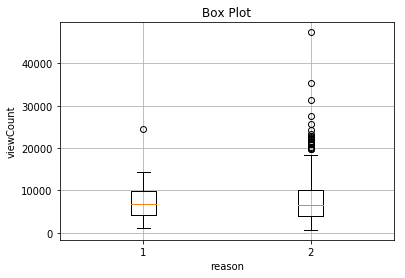

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.boxplot([reason, non_reason])
plt.xlabel('reason')
plt.ylabel('viewCount')
plt.title('Box Plot')
plt.grid()
plt.show()

# Results
제목에 이유가 있는 영상의 조회수 평균은 7,269회  
제목에 이유가 없는 영상의 조회수 평균은 7,593회   
(p=0.742)  

# Conclusion
제목에 '이유'가 들어가나 안 들어가나 큰 차이가 없다.